#ST 563 Project
##- David Grant

###Analyzing Pokemon Go Data:

For this project, I will be analyzing data from Pokemon Go. The datatset comes from Kaggle, linked here: https://www.kaggle.com/datasets/siropo/pokemon-go-pvp-stats


This datatset is specifically concerned about a Pokemon's viability in the Great League, a battle league where trainers compete 1 on 1 with 3 pokemon each, where the maximum combat power (CP) of a Pokemon is capped at 1500.

The variable of interest I will be modeling in this dataset is the *score* variable. The score variable is a score designated by the website https://pvpoke.com/ that represents a Pokemon's general viability in the Great League.

The main purpose of this project is to determine which features play the largest role in influencing this score variable. This means I will be more focused on *inference* as opposed to *prediction*. There is little need for prediction because all Pokemon scores are already known (via pvpoke), and so I don't really need to guess whether a Pokemon is generally viable or not. However, it is important to know which variables play more or less of a factor in determining the Pokemon's score, because in order to make any Pokemon viable for battle, I have to level them up or teach them new attacks, which often costs resources. If I can learn which predictors are important or not, then I can use that information to determine if it's worth spending resources on a Pokemon to use them for battle.

Hopefully by the end of this project I'll have an idea of which factors are the most and least important when determining the Pokemon's score. Factors I'll be assessing are the pokemon's ability stats, and information regarding their fast and charged moves, such as how much damage they can deal as well as how quickly.

Reading in the data.

In [126]:
pokemon_data <- read.csv('/content/sample_data/pogo_meta_data.csv')

Data Cleaning

In [127]:
#First going to rename some of the columns to be more descriptive
names(pokemon_data)[names(pokemon_data) == 'Type.1'] <- 'Primary Type'
names(pokemon_data)[names(pokemon_data) == 'Type.2'] <- 'Secondary Type'
names(pokemon_data)[names(pokemon_data) == 'Fast.Move'] <- 'Fast Move'
names(pokemon_data)[names(pokemon_data) == 'Charged.Move.1'] <- 'Charged Move 1'
names(pokemon_data)[names(pokemon_data) == 'Charged.Move.2'] <- 'Charged Move 2'
names(pokemon_data)[names(pokemon_data) == 'Damage_CM_1'] <- 'CM1.Damage'
names(pokemon_data)[names(pokemon_data) == 'Energy_CM_1'] <- 'CM1.EnergyCost'
names(pokemon_data)[names(pokemon_data) == 'DPE_CM_1'] <- 'CM1.DPE'
names(pokemon_data)[names(pokemon_data) == 'Damage_CM_2'] <- 'CM2.Damage'
names(pokemon_data)[names(pokemon_data) == 'Energy_CM_2'] <- 'CM2.EnergyCost'
names(pokemon_data)[names(pokemon_data) == 'DPE_CM_2'] <- 'CM2.DPE'
names(pokemon_data)[names(pokemon_data) == 'Damage_FM'] <- 'FM.Damage'
names(pokemon_data)[names(pokemon_data) == 'Turns_FM'] <- 'FM.Turns'
names(pokemon_data)[names(pokemon_data) == 'Energy_FM'] <- 'FM.EnergyGain'
names(pokemon_data)[names(pokemon_data) == 'CD_FM'] <- 'FM.Time'
names(pokemon_data)[names(pokemon_data) == 'DPT_FM'] <- 'FM.DamagePerTurn'
names(pokemon_data)[names(pokemon_data) == 'EPT_FM'] <- 'FM.EnergyGainPerTurn'

Upon further inspection of the data, the variables FM.Turns and FM.Time are essentially the same variable. Each turn in a battle is 0.5 seconds, which a trainer can use either a fast move, charged move, or switch out a Pokemon.

FM.Turns represents how quickly the fast move executes according to the "gamemaster" where a value of 0 represents the quickest possible fast move, of 0.5 seconds, and each additional "point" represents an additional 0.5 seconds. So a value of 1 = 1 second, 2 = 1.5 seconds, 3 = 2 seconds, etc...

Whereas FM.Time is simply the time in seconds it takes to execute the move. So 0.5 is the minimum value here which represents 0.5 seconds it takes to execute the move. Because these columns are perfectly correlated, there is no need to use both of them for this project, and so I will be dropping the FM.Turns column. There are 2 reasons why I am dropping FM.Turns as opposed to FM.Time:
1. FM.Time has a slightly easier interpretation, especially if needing to do splits on the variable (it's simply the time).
2. Don't have to worry about having values of 0 when using FM.Time, which could help with visual representations on graphs.

In [128]:
#Dropping FM.Turns
pokemon_data <- pokemon_data[-20]

Also upon further inspection, there appear to be some duplicate rows. I am unaware as to the reason why there are duplicate rows, but it is important that the duplicates are removed.

In [129]:
#Remove the duplicated rows and renumber the rows so there's no gaps
pokemon_data <- pokemon_data[!duplicated(pokemon_data), ]
row.names(pokemon_data) <- 1:nrow(pokemon_data)

Also want to check for any missing values.

In [130]:
#Check for any missing values
sum(is.na(pokemon_data))

[1] 0

Splitting the data- I'm going to split the data into a 70/30 train/test split

In [131]:
#Setting seed and splitting the data
set.seed(555)
n <- nrow(pokemon_data)

index <- sample(x=1:n, size=round(0.7*n), replace=FALSE)

pokemon_train <- pokemon_data[index, ]
pokemon_test <- pokemon_data[-index, ]

colnames(pokemon_test)

[1] "Pokemon"              "Score"                "Primary Type"        
 [4] "Secondary Type"       "Attack"               "Defense"             
 [7] "Stamina"              "Stat.Product"         "Level"               
[10] "Fast Move"            "Charged Move 1"       "Charged Move 2"      
[13] "CM1.Damage"           "CM1.EnergyCost"       "CM1.DPE"             
[16] "CM2.Damage"           "CM2.EnergyCost"       "CM2.DPE"             
[19] "FM.Damage"            "FM.EnergyGain"        "FM.Time"             
[22] "FM.DamagePerTurn"     "FM.EnergyGainPerTurn"

#Model Building

##Model 1: MLR Model

The first model I will be building to analyze the Pokemon's great league score is a MLR model, where I will be performing backward selection in order to choose which variables at each number of predictors are most important to the model, and then compare the models with each number of predictors using aic, bic, and adjr2 to choose the best model.

Note: I am not including the names of the fast and charged moves, since the names of the moves themselves don't matter, whereas the attributes of the moves (such as damage, time, energy gain, etc...) do.

I am also not including the Pokemon's type(s). Now it's worth noting that a Pokemon will get a 50% damage bonus to whichever of their moves (charged or fast) are the same type as the Pokemon's type (this is known as "same type attack damage", or STAB). However, this dataset does not list the move's type for each Pokemon, so the STAB bonus isn't reflected in the numbers, making the type irrelevant.

I could manually a column listing the type for each specific move in the data set (though this is time-consuming), and then I'd be able to determine if the Pokemon gets a STAB bonus or not, which could be useful to determine their score. However, taking a quick glance at the dataset, just about all the Pokemon listed already have listed moves of the same type anyway, meaning the attributes associated with these moves (specifically the damage) are already scaled correctly relative to each other.

So for now my goal is to simply look at the raw stats of the moves themselves without having to worry about if they have STAB or not. But it is a problem to potentially consider for the future (also when I have more time).

In [175]:
#Perform backward selection
#install.packages("leaps")
library(leaps)

backward_model <- regsubsets(Score ~ Attack + Defense + Stamina + Stat.Product + Level + CM1.Damage + CM1.EnergyCost
      + CM1.DPE + CM2.Damage + CM2.EnergyCost + CM2.DPE + FM.Damage + FM.EnergyGain + FM.Time + FM.DamagePerTurn + FM.EnergyGainPerTurn,
      data = pokemon_train,
      nvmax = 16,
      method = "backward")
mod_summary <- summary(backward_model)
mod_summary

Subset selection object
Call: regsubsets.formula(Score ~ Attack + Defense + Stamina + Stat.Product + 
    Level + CM1.Damage + CM1.EnergyCost + CM1.DPE + CM2.Damage + 
    CM2.EnergyCost + CM2.DPE + FM.Damage + FM.EnergyGain + FM.Time + 
    FM.DamagePerTurn + FM.EnergyGainPerTurn, data = pokemon_train, 
    nvmax = 16, method = "backward")
16 Variables  (and intercept)
                     Forced in Forced out
Attack                   FALSE      FALSE
Defense                  FALSE      FALSE
Stamina                  FALSE      FALSE
Stat.Product             FALSE      FALSE
Level                    FALSE      FALSE
CM1.Damage               FALSE      FALSE
CM1.EnergyCost           FALSE      FALSE
CM1.DPE                  FALSE      FALSE
CM2.Damage               FALSE      FALSE
CM2.EnergyCost           FALSE      FALSE
CM2.DPE                  FALSE      FALSE
FM.Damage                FALSE      FALSE
FM.EnergyGain            FALSE      FALSE
FM.Time                  FALSE      FAL

In [176]:
#Using aic/bic/adjr2 to choose the best model from backward selection
metrics <- data.frame(aic = mod_summary$cp,
                      bic = mod_summary$bic,
                      adjr2 = mod_summary$adjr2)
metrics

aic,bic,adjr2
<dbl>,<dbl>,<dbl>
880.85807,-132.9714,0.2721284
702.93039,-192.7983,0.3691385
313.77984,-375.2251,0.5826151
195.02956,-447.6844,0.6481674
124.55139,-496.2202,0.6873757
71.01489,-536.9408,0.7173900
52.42033,-549.4984,0.7281714
33.00252,-563.6536,0.7394587
23.89992,-568.4122,0.7450535


Looking at the results of the model using backward selection, the aic and adjuted r2 suggest to use a model with 11 predictors, since that's the highest adjusted r2 and the lowest aic. However, bic suggests a more parsimonious model, only including 10 factors in the best model, as that is the one with the lowest bic. I will consider this model to be the best MLR model, since it has the lowest bic, and 10 variables is plenty to determine which ones are important.

The predictors in this best model with 10 variables are: attack, stamina, stat prodcut, CM1.Damage, CM1.EnergyCost, CM2.Damage, CM2.EnergyCost,
FM.Damage, FM.DamagePerTurn, and FM.EnergyGainPerTurn.

The MLR model does not inherently perform variable selection, however, that was performed above with backward selection. The predictors do not need to be standardized. It is a parametric model with no inherent tuning parameters. However, we did choose the optimal number of predictors above using bic.

(Intercept)               Attack              Stamina 
       -5.615304e+01         9.010463e-02         3.565802e-02 
        Stat.Product           CM1.Damage       CM1.EnergyCost 
        3.095070e-05         1.277474e-01         5.750045e-01 
          CM2.Damage       CM2.EnergyCost            FM.Damage 
        7.799898e-02         2.899739e-01        -6.957604e-01 
    FM.DamagePerTurn FM.EnergyGainPerTurn 
        1.182137e+01         1.582651e+01

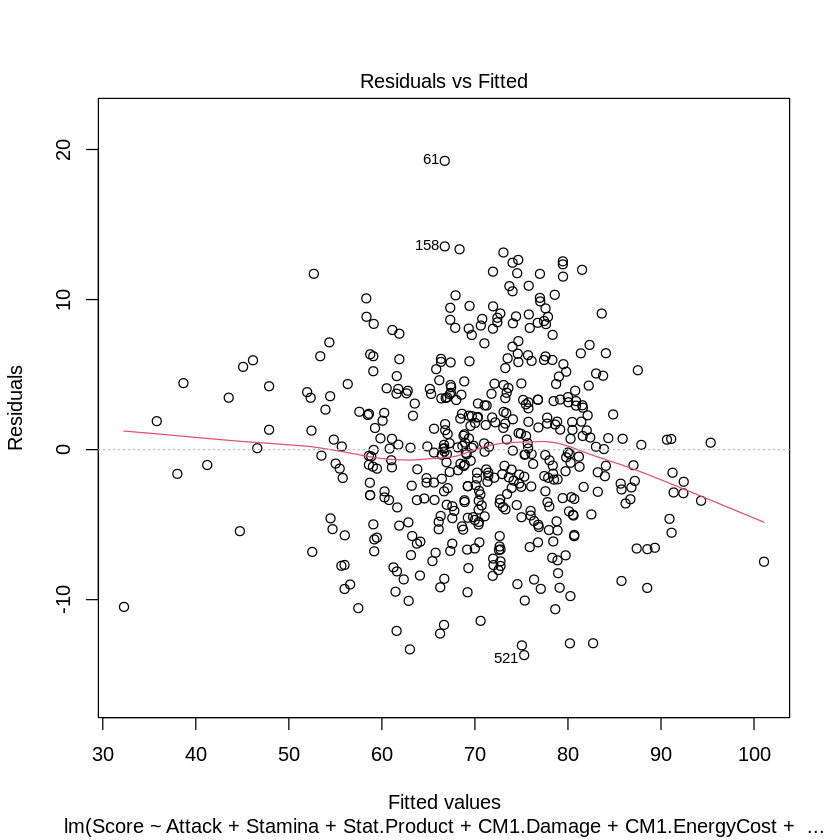

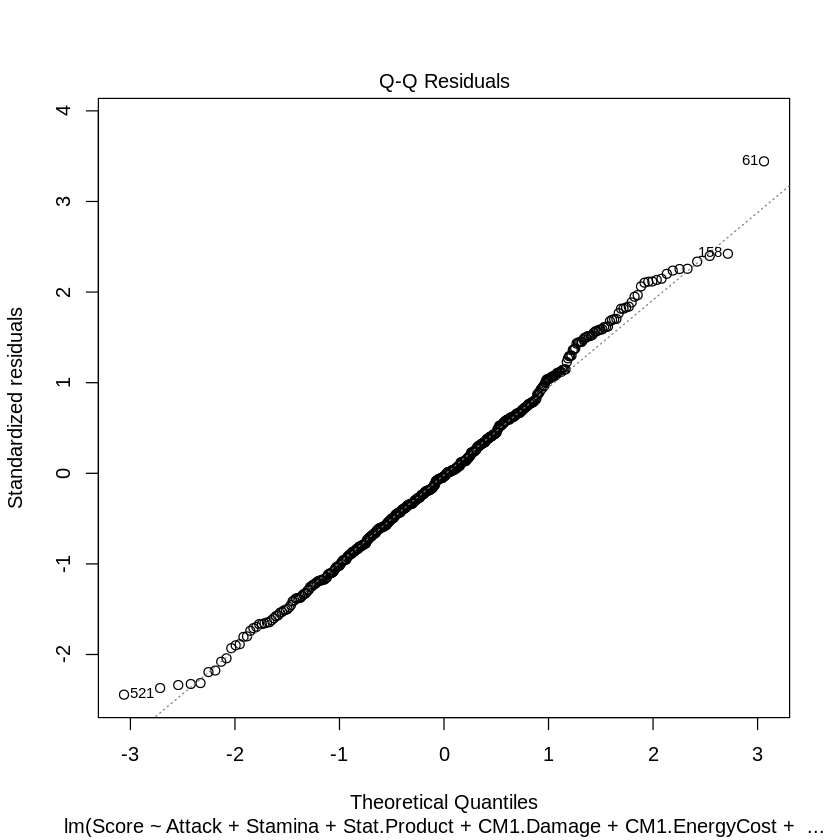

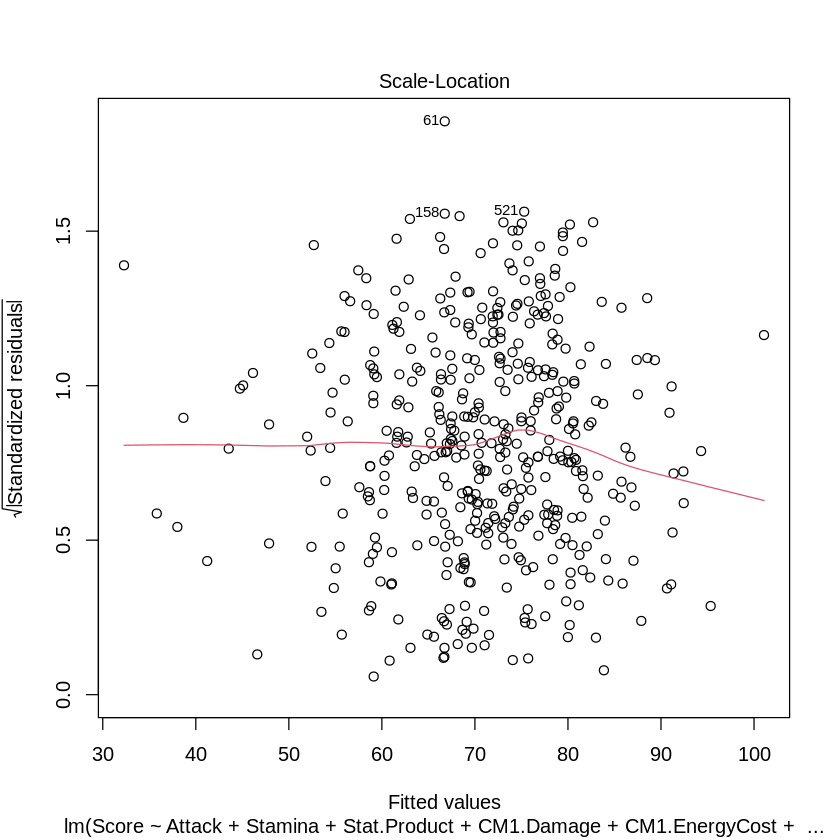

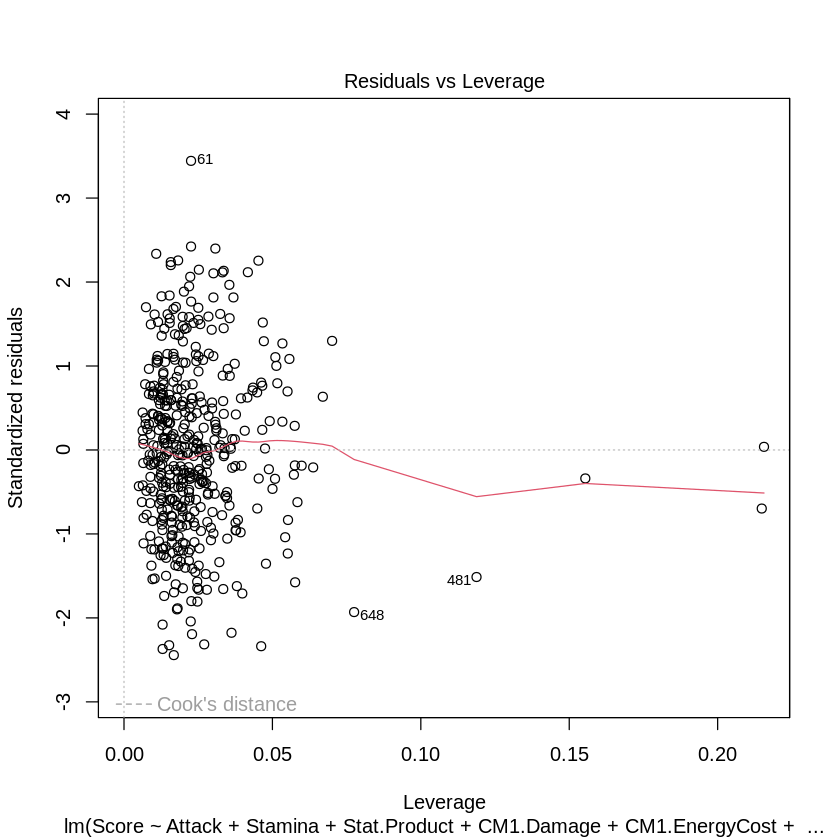

In [134]:
#Train the MLR model
pokemon_mlr <- lm(Score ~ Attack + Stamina + Stat.Product + CM1.Damage + CM1.EnergyCost + CM2.Damage + CM2.EnergyCost
                  + FM.Damage + FM.DamagePerTurn + FM.EnergyGainPerTurn,
                  data = pokemon_train)
round(pokemon_mlr$coefficients, 10)
plot(pokemon_mlr)

##Model 2: K-Nearest Neighbors Model

The next model I'll be building is a k-nearest neighbors (knn) model, which is a non-parametric model. There is a tuning parameter for this model, k, which is the number of nearest neighbors we use. The kNN algorithm itself doesn't perform variable selection. We once again don't need to standardize the predictors here. kNN can be used for inference, although this is a model that is probably preferred more for prediction.

The predictors I am using for this model are the 5 most influential predictors that were still in the model performed earlier from the backward selection. These predictors are Stat.Product, CM1.Damage, CM1.EnergyCost, FM.DamagePerTurn, and FM.EnergyGainPerTurn. The reason I am choosing 5 predictors is because it's not too many to be over-variant (especially when considering the curse of dimensionality), but not too little to be too biased either.

[1] 45

,k,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
45,45,9.351865,0.3251671,7.503434,1.197428,0.1140208,0.9431721


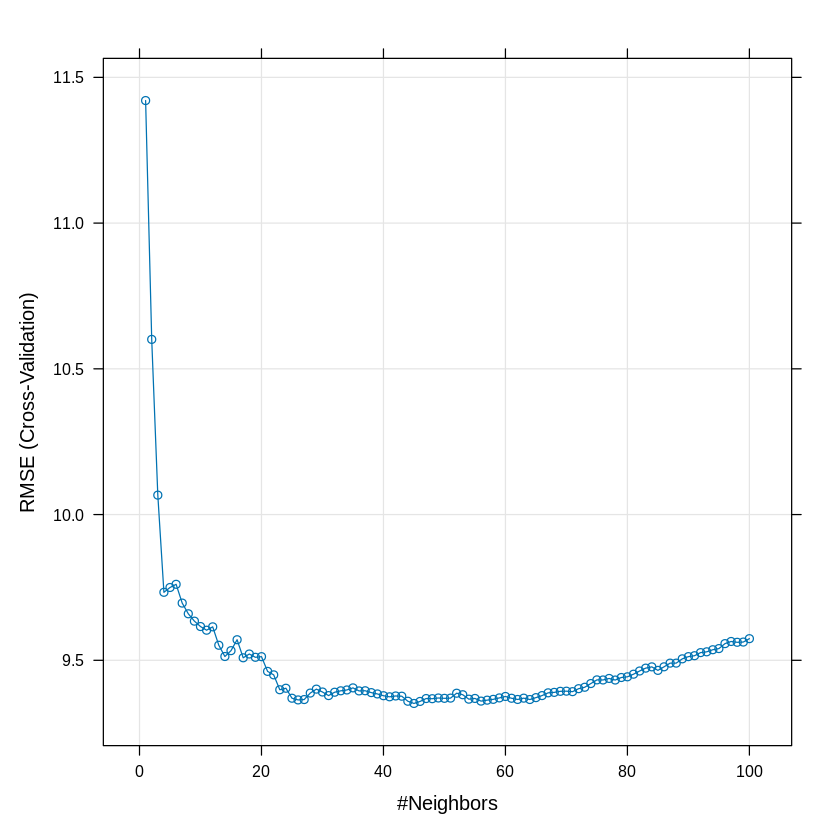

In [135]:
library(kknn)
set.seed(555)
kgrid <- expand.grid(k = 1:100)
cv <- trainControl(method = "cv",
                   number = 10)
pokemon_knn <- train(Score ~ Stat.Product + CM1.Damage + CM1.EnergyCost + FM.DamagePerTurn + FM.EnergyGainPerTurn,
                     data = pokemon_train,
                     method = "knn",
                     tuneGrid = kgrid,
                     trControl = cv)
k_opt <- pokemon_knn$bestTune$k
k_opt
pokemon_knn$results[k_opt, ]
plot(pokemon_knn)

Based on the results above, the optimal k-value for this model is 45. Now I will train the entire training set to this model with the optimal k-value

In [136]:
pokemon_knn_tuned <- train(Score ~ Stat.Product + CM1.Damage + CM1.EnergyCost + FM.DamagePerTurn + FM.EnergyGainPerTurn,
                           data = pokemon_train,
                           method = "knn",
                           tuneGrid = pokemon_knn$bestTune,
                           trControl = trainControl(method = "none"))
pokemon_knn_tuned

k-Nearest Neighbors 

454 samples
  5 predictor

No pre-processing
Resampling: None 

##Model 3: Piecewise Polynomial Regression- Natural Cubic Spline

For the next model, I will be making a natural cubic spline model. A natural cubic spline model is non-parametric since there's isn't exact form. This is because it also has a tuning parameter, which is the number and location of the knots in the model. The knots determine where and how the model gets "sliced" so to speak. The natural cubic spline model does not perform variable selection nor do the predictors need to be standardized. Similar to kNN, it can be used for inference, however, I would expect that it has better uses for prediction.

For simplicity and visual sake, I will be using only one predictor in this model, which is Stat.Product. This was the only variable left in backward selection when we went down to 1 variable, which indicates it could be the most important variable.

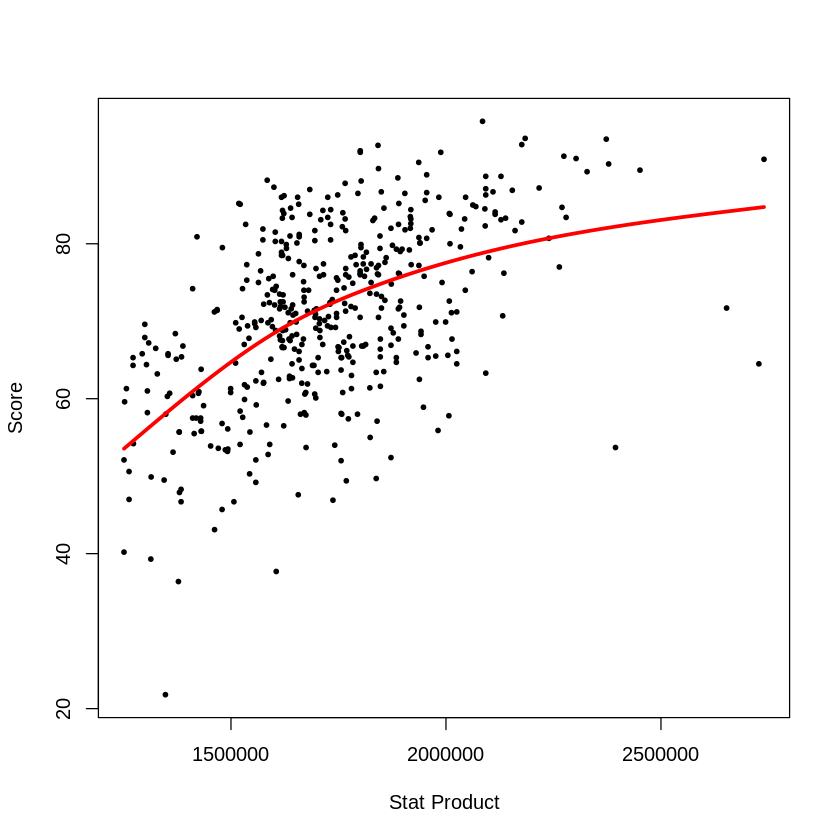

In [170]:
library(splines)
#Linear model fit for natural spline
pokemon_ns <- lm(Score ~ ns(Stat.Product, df=3), data = pokemon_train)
#Grid for prediction
xgrid <- seq(min(pokemon_train$Stat.Product), max(pokemon_train$Stat.Product), len = 101)
pred <- predict(pokemon_ns, newdata = data.frame(Stat.Product = xgrid))

#Estimated function plot
plot(pokemon_train$Stat.Product, pokemon_train$Score,
     xlab = "Stat Product", ylab = "Score", pch = 19, cex = 0.5)
lines(xgrid, pred,
      lwd = 3, col = "Red")

##Model 4: Single Tree Model

The next model I'll be building is a single tree model. This model is a non-parametric model, since there isn't a fixed form for it. You can essentially split the tree however necessary. There are multiple tuning parameters for this tree model. One of them is the optimal cutoff value at each split. The other is deciding how many splits are necessary. This model can be used for inference. The predictors do not need to be standardized. The tree does perform variable selection, since it needs to decide which variable is the most important at each split. This could cause it to not use any variables at all, and use some more often than others.

For this tree, I decided to have a minimum bucket size of 8 at the leaves, since the training set has about 450 observations, I didn't want to make the bucket sizes too small and run the risk of overfitting.

In [152]:
#install.packages("rpart")
library(rpart)
set.seed(555)
T0 <- rpart(Score ~ Attack + Defense + Stamina + Stat.Product + Level + CM1.Damage + CM1.EnergyCost
            + CM1.DPE + CM2.Damage + CM2.EnergyCost + CM2.DPE + FM.Damage + FM.EnergyGain + FM.Time + FM.DamagePerTurn + FM.EnergyGainPerTurn,
            data = pokemon_train,
            control = rpart.control(xval = 10, minbucket = 8, cp = 0))
printcp(T0)


Regression tree:
rpart(formula = Score ~ Attack + Defense + Stamina + Stat.Product + 
    Level + CM1.Damage + CM1.EnergyCost + CM1.DPE + CM2.Damage + 
    CM2.EnergyCost + CM2.DPE + FM.Damage + FM.EnergyGain + FM.Time + 
    FM.DamagePerTurn + FM.EnergyGainPerTurn, data = pokemon_train, 
    control = rpart.control(xval = 10, minbucket = 8, cp = 0))

Variables actually used in tree construction:
 [1] Attack               CM1.DPE              CM1.EnergyCost      
 [4] CM2.Damage           CM2.DPE              CM2.EnergyCost      
 [7] Defense              FM.Damage            FM.DamagePerTurn    
[10] FM.EnergyGainPerTurn FM.Time              Level               
[13] Stat.Product        

Root node error: 57904/454 = 127.54

n= 454 

          CP nsplit rel error  xerror     xstd
1  0.2346780      0   1.00000 1.00365 0.071790
2  0.0731397      1   0.76532 0.80505 0.056806
3  0.0383095      2   0.69218 0.73521 0.056023
4  0.0351813      3   0.65387 0.72541 0.055185
5  0.0283756      4

Based on output minimum error corresponds with CP value of 0.0110183. This corresponds to a tree with 12 splits.

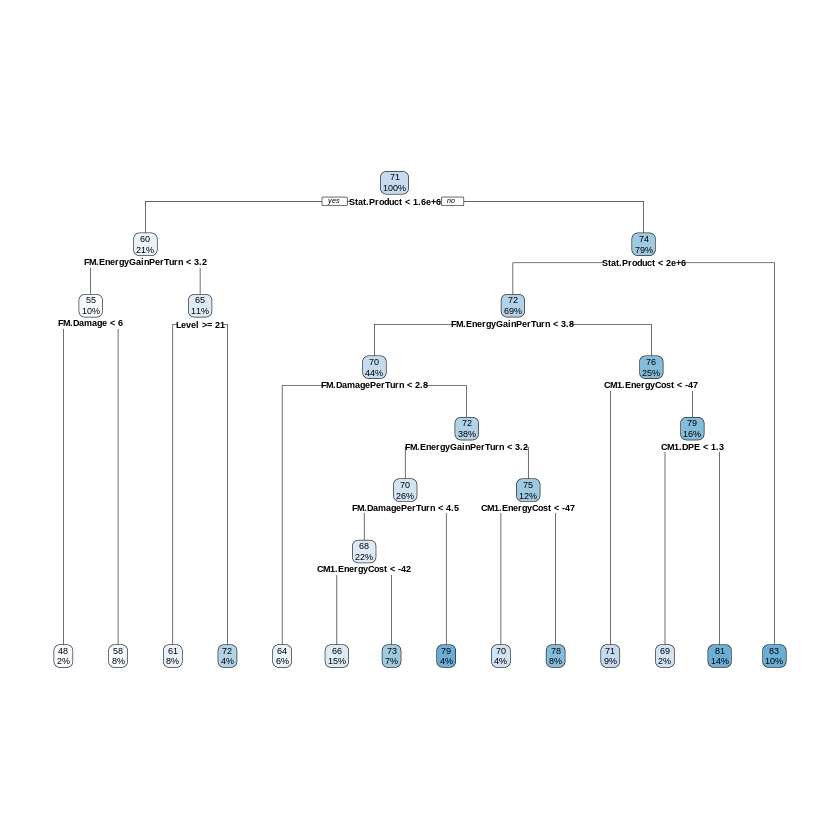

In [158]:
#install.packages("rpart.plot")
library(rpart.plot)
final <- prune(T0, cp = 0.0110183)
rpart.plot(final)

##Model 5: Ensemble Tree Model

My next model is using a random forest tree ensemble. This model, similar to the singlular tree model, is non-parametric, and has tuning parameters of how many splits are needed as well the best values at each split. However, unlike the singular tree model, it considers a different set of predictors for each tree within it. We can use the model for inference, especially for determining which variables are important or not. We don't need to standardize the predictors, and the model also performs variable selection.

In [154]:
#install.packages("caret")
#install.packages("randomForest")
library(randomForest)
library(caret)
set.seed(555)

pokemon_bagged <- train(Score ~ Attack + Defense + Stamina + Stat.Product + Level + CM1.Damage + CM1.EnergyCost
                        + CM1.DPE + CM2.Damage + CM2.EnergyCost + CM2.DPE + FM.Damage + FM.EnergyGain + FM.Time + FM.DamagePerTurn + FM.EnergyGainPerTurn,
                        method = "rf",
                        data = pokemon_train,
                        tuneGrid = data.frame(mtry = 1:16),
                        trControl = trainControl(method = "oob", number = 2000))
round(pokemon_bagged$results, 4)
pokemon_bagged$bestTune

,RMSE,Rsquared,mtry
,<dbl>,<dbl>,<dbl>
1,7.7296,0.5316,1
2,7.2284,0.5903,2
3,7.0376,0.6117,3
4,6.9993,0.6159,4
5,6.8358,0.6336,5
6,6.8598,0.6310,6
7,6.8333,0.6339,7
8,6.8677,0.6302,8
9,6.7953,0.6380,9


,mtry
,<int>
13,13


,Overall
,<dbl>
Attack,11.5854
Defense,13.2643
Stamina,7.4781
Stat.Product,100.0000
Level,15.0539
CM1.Damage,2.3081
CM1.EnergyCost,13.1258
CM1.DPE,11.8269
CM2.Damage,1.8567


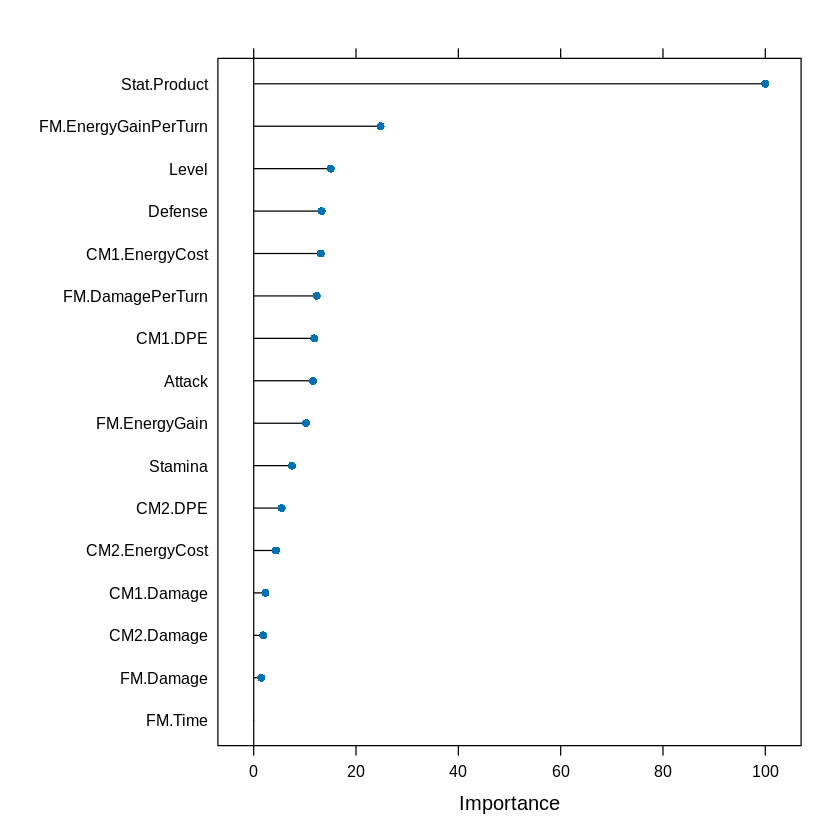

In [155]:
round(varImp(pokemon_bagged)$importance, 4)
plot(varImp(pokemon_bagged))

Looking at the output above, we see that Stat.Product is clearly the most important variable. This is consistent with the backward selection performed earlier where Stat.Product was the only variable in the model using just 1 predictor. FM.EnergyGainPerTurn was the 2nd most important variable, and after that, there are several variables at roughly the same level.

##Model 6: Support Vector Machines

The final model I will be building is a support vector machine. Typically, these models are used for classification tasks, but they can be used for regression tasks as well, which is what I'm doing here, again only using the Stat.Product variable. SVM's are non-parametric and have a tuning parameter. They can be used for inference, although they seem better for prediction, especially among classification tasks. Predictors do need to standardized here, and they can also perform variable selection.

In [92]:
#install.packages("e1071")
library(e1071)
pokemon_sv <- svm(Score ~ Stat.Product, data = pokemon_train,
                  type = "eps-regression",
                  kernel = "radial", gamma = 1,
                  cost = 1, epsilon = 0.1)
pokemon_sv


Call:
svm(formula = Score ~ Stat.Product, data = pokemon_train, type = "eps-regression", 
    kernel = "radial", gamma = 1, cost = 1, epsilon = 0.1)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  1 
    epsilon:  0.1 


Number of Support Vectors:  413


#Model Testing

Now that all 6 models are built, I will find the test error for each one by finding the sum of squared errors of new observations that were held out in the test set.

In [177]:
#Get the predictions for the new data
mlr_preds <- predict(pokemon_mlr, newdata = pokemon_test)
knn_preds <- predict(pokemon_knn, newdata = pokemon_test)
ns_preds <- predict(pokemon_ns, newdata = pokemon_test)
single_tree_preds <- predict(final, newdata = pokemon_test)
forest_preds <- predict(pokemon_bagged, newdata = pokemon_test)
svm_preds <- predict(pokemon_sv, newdata = pokemon_test)

#Find the test error for each model
paste("MLR Test Error:", round(mean((pokemon_test$Score - mlr_preds)^2), 3))
paste("kNN Test Error:", round(mean((pokemon_test$Score - knn_preds)^2), 3))
paste("Cubic Spline Test Error:", round(mean((pokemon_test$Score - ns_preds)^2), 3))
paste("Single Tree Test Error:", round(mean((pokemon_test$Score - single_tree_preds)^2), 3))
paste("Random Forest Test Error:", round(mean((pokemon_test$Score - forest_preds)^2), 3))
paste("SVM Test Error:", round(mean((pokemon_test$Score - svm_preds)^2), 3))


[1] "MLR Test Error: 31.168"

[1] "kNN Test Error: 95.95"

[1] "Cubic Spline Test Error: 96.838"

[1] "Single Tree Test Error: 77.134"

[1] "Random Forest Test Error: 42.496"

[1] "SVM Test Error: 101.13"

#Final Model Selection

Looking at the test errors, the MLR model has the lowest test error. However, as mentioned at the beginning, the main goal of this project is to determine which factors are the most important, not necessarily prediction on new values. With that in mind, and since the random forest test error wasn't too much higher relatively speaking, I will actually choose the random forest model as my final model. I am willing to sacrifice perhaps that little bit of prediction accuracy if it means I get a better understanding of how important each predictor variable is in determining the Pokemon's score.

It would be unwise to choose just about any other model as A. some of them are more geared towards prediction, and B. they have much higher test errors anyway. MLR and the random forest models are the only 2 reasonable models to use here. But as mentioned above, I will choose the random forest model as my final model, which I'll fit to the entire data set.

In [159]:
#Fitting the random forest model on the entire data set
set.seed(555)

pokemon_final <- train(Score ~ Attack + Defense + Stamina + Stat.Product + Level + CM1.Damage + CM1.EnergyCost
                        + CM1.DPE + CM2.Damage + CM2.EnergyCost + CM2.DPE + FM.Damage + FM.EnergyGain + FM.Time + FM.DamagePerTurn + FM.EnergyGainPerTurn,
                        method = "rf",
                        data = pokemon_data,
                        tuneGrid = data.frame(mtry = 1:16),
                        trControl = trainControl(method = "oob", number = 2000))
round(pokemon_final$results, 4)
pokemon_final$bestTune

,RMSE,Rsquared,mtry
,<dbl>,<dbl>,<dbl>
1,7.2059,0.6020,1
2,6.5809,0.6680,2
3,6.4176,0.6843,3
4,6.2767,0.6980,4
5,6.1804,0.7072,5
6,6.1163,0.7133,6
7,6.0805,0.7166,7
8,6.0366,0.7207,8
9,6.0475,0.7197,9


,mtry
,<int>
13,13


,Overall
,<dbl>
Attack,10.9404
Defense,9.9421
Stamina,5.8545
Stat.Product,100.0000
Level,19.3364
CM1.Damage,1.1484
CM1.EnergyCost,17.0213
CM1.DPE,10.4399
CM2.Damage,0.8397


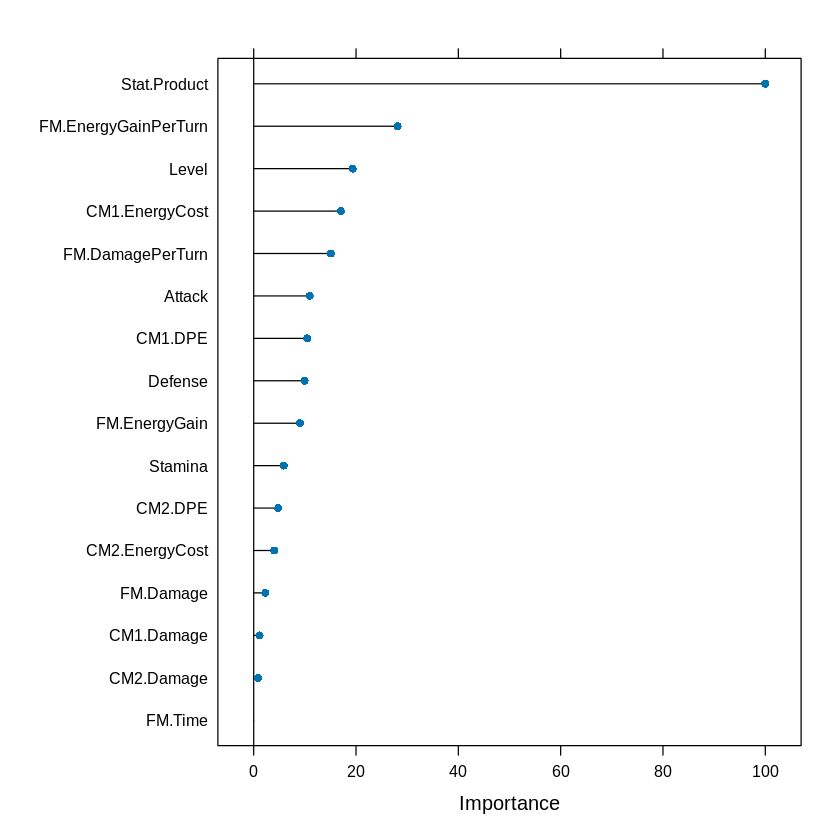

In [161]:
#Checking importance of each variable
round(varImp(pokemon_final)$importance, 4)
plot(varImp(pokemon_final))

#Conclusion

Looking at the final model above, the Stat.Product is clearly the most important variable. This means it's important for the Pokemon to have good base stats across the board. FM.EnergyGainPerTurn is the next most important variable, which is basically how much the fast move fills up the charge move. So it's important to fill up the charged move quickly.

FM.Damage, CM1.Damage, and CM2.Damage are all pretty unimportant according to this output, so the amount of damage a move does really doesn't matter. However, the DPE, or damage per turn for the moves, is more important, which intuitively makes sense as well.

Some things to keep in mind however- this data is only for Great League, and so this will most likely be different for other leagues such as Master and Ultra League. So this should only be used to assess Pokemon with a CP level <= 1500.

Additionally, it is not wise to just try to pick the best Pokemon based on their Score alone for your lineup. Lineup synergy and battle strategy matters as well.

Going forward, the conclusions I've made from this project will help me assess whether or not I should spend resources on a Pokemon and if so which resources. Based on these results, it may be worth it to spend Fast TM's to try to get a fast move that can fill up the charged attack more quickly. However, it doesn't seem worth investing much into a 2nd charged move, since the stats associated with those don't seem that important.

Overall this project was really fun and I feel may actually help me with my battles. But I do want to investigate at a later point in time how much the same-type attack damage (STAB) plays a role as well.